In [1]:
# Fake News Detection - Machine Learning Project
# This notebook fetches news articles from an API, preprocesses the text,
# and uses machine learning to classify articles as real or fake news

# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ankus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankus\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ankus\AppData\Roaming\nltk_data...


True

In [4]:
# 1. Data Collection
# -----------------

# Function to fetch news from News API
def fetch_news_from_api(api_key, category='general', country='us', page_size=100):
    """
    Fetch news articles from News API
    
    Parameters:
    api_key (str): Your News API key
    category (str): News category (business, entertainment, general, health, science, sports, technology)
    country (str): Two-letter country code
    page_size (int): Number of articles to fetch (max 100)
    
    Returns:
    list: List of news articles with 'title', 'description', and 'content'
    """
    base_url = "https://newsapi.org/v2/top-headlines"
    
    params = {
        'apiKey': api_key,
        'country': country,
        'category': category,
        'pageSize': page_size
    }
    
    try:
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            articles = data.get('articles', [])
            
            # Extract relevant fields
            processed_articles = []
            for article in articles:
                if article['title'] and article['description']:
                    processed_articles.append({
                        'title': article['title'],
                        'description': article['description'],
                        'content': article['content'] if article['content'] else ''
                    })
            
            return processed_articles
        else:
            print(f"Error fetching news: {response.status_code}")
            return []
    except Exception as e:
        print(f"Exception during API call: {e}")
        return []

# Note: For a real project, you would add your News API key here
# api_key = "YOUR_NEWS_API_KEY"
# real_news = fetch_news_from_api(api_key)
# We'll use sample data for demonstration purposes since we don't have an actual API key

In [5]:

# 2. Load Sample Datasets
# ----------------------
# In a real implementation, we would use the API data, but for this example,
# we'll load a pre-existing fake news dataset

# For demonstration purposes, we'll use a combination of the fake and real news datasets
print("Loading sample datasets...")

# In a real notebook, you would download these datasets or use your API data
# URL for fake news dataset: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

# Simulate loading datasets
def load_sample_data():
    """
    Load and combine fake and real news datasets
    
    Returns:
    DataFrame: Combined dataset with 'text' and 'label' columns
    """
    # In an actual implementation, you would read CSV files:
    # fake_df = pd.read_csv('fake.csv')
    # real_df = pd.read_csv('true.csv')
    
    # For demonstration, create a small sample dataset
    fake_texts = [
        "BREAKING: President secretly working with aliens to hide UFO evidence",
        "Doctors don't want you to know this miracle cure for all diseases",
        "Celebrity confirms government mind control through drinking water",
        "Secret document reveals banks are preparing for economic collapse next week",
        "Scientists discover COVID vaccine contains tracking microchips"
    ]
    
    real_texts = [
        "Study finds regular exercise may reduce risk of certain health conditions",
        "New climate report warns of rising sea levels affecting coastal cities",
        "Tech company announces quarterly earnings exceeding analyst expectations",
        "Government passes infrastructure bill aimed at improving national transportation",
        "Research shows benefits of Mediterranean diet for heart health"
    ]
    
    fake_df = pd.DataFrame({
        'text': fake_texts,
        'label': 0  # 0 for fake news
    })
    
    real_df = pd.DataFrame({
        'text': real_texts,
        'label': 1  # 1 for real news
    })
    
    # Combine the datasets
    combined_df = pd.concat([fake_df, real_df], ignore_index=True)
    
    # Shuffle the data
    return combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Load the sample data
news_df = load_sample_data()

# Display the first few rows
print("Dataset preview:")
display(news_df.head())

# Check class distribution
print("\nClass distribution:")
print(news_df['label'].value_counts())


Loading sample datasets...
Dataset preview:


,text,label
0,Government passes infrastructure bill aimed at...,1
1,Doctors don't want you to know this miracle cu...,0
2,Study finds regular exercise may reduce risk o...,1
3,BREAKING: President secretly working with alie...,0
4,Tech company announces quarterly earnings exce...,1



Class distribution:
label
1    5
0    5
Name: count, dtype: int64


In [6]:

# 3. Text Preprocessing
# --------------------

# Function to preprocess text
def preprocess_text(text):
    """
    Clean and preprocess text for machine learning
    
    Parameters:
    text (str): Raw text
    
    Returns:
    str: Preprocessed text
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply preprocessing to the dataset
print("Preprocessing text data...")
news_df['processed_text'] = news_df['text'].apply(preprocess_text)

# Display examples of preprocessed text
print("\nPreprocessed text examples:")
for i in range(2):
    print(f"Original: {news_df['text'][i]}")
    print(f"Processed: {news_df['processed_text'][i]}")
    print()

Preprocessing text data...

Preprocessed text examples:
Original: Government passes infrastructure bill aimed at improving national transportation
Processed: government pass infrastructure bill aimed improving national transportation

Original: Doctors don't want you to know this miracle cure for all diseases
Processed: doctor dont want know miracle cure disease



In [7]:

# 4. Feature Extraction
# --------------------

print("Extracting features using TF-IDF...")

# Split data into training and testing sets
X = news_df['processed_text']
y = news_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")

Extracting features using TF-IDF...
Training data shape: (8, 63)
Testing data shape: (2, 63)


In [8]:
# 5. Model Training
# ----------------

print("Training a Logistic Regression model...")

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)


Training a Logistic Regression model...


LogisticRegression(max_iter=1000, random_state=42)

Evaluating the model...
Accuracy: 0.0000

Classification Report:
              precision    recall  f1-score   support

   Fake News       0.00      0.00      0.00       2.0
   Real News       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_cla

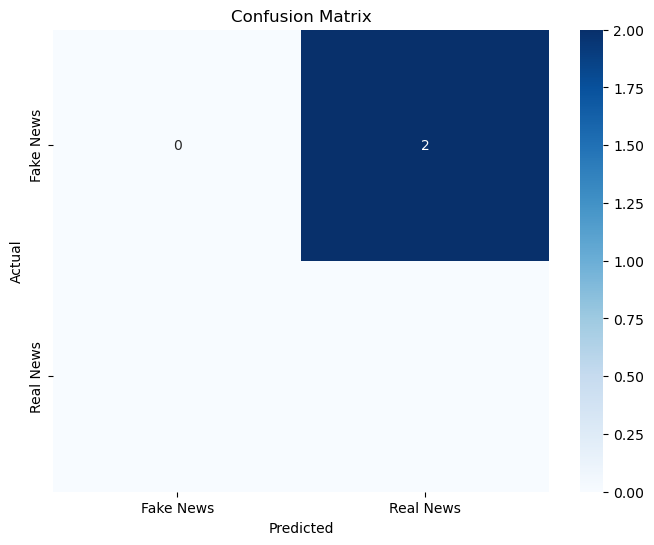

In [9]:
# 6. Model Evaluation
# -----------------

print("Evaluating the model...")

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake News', 'Real News']))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake News', 'Real News'], yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Analyzing most indicative features...


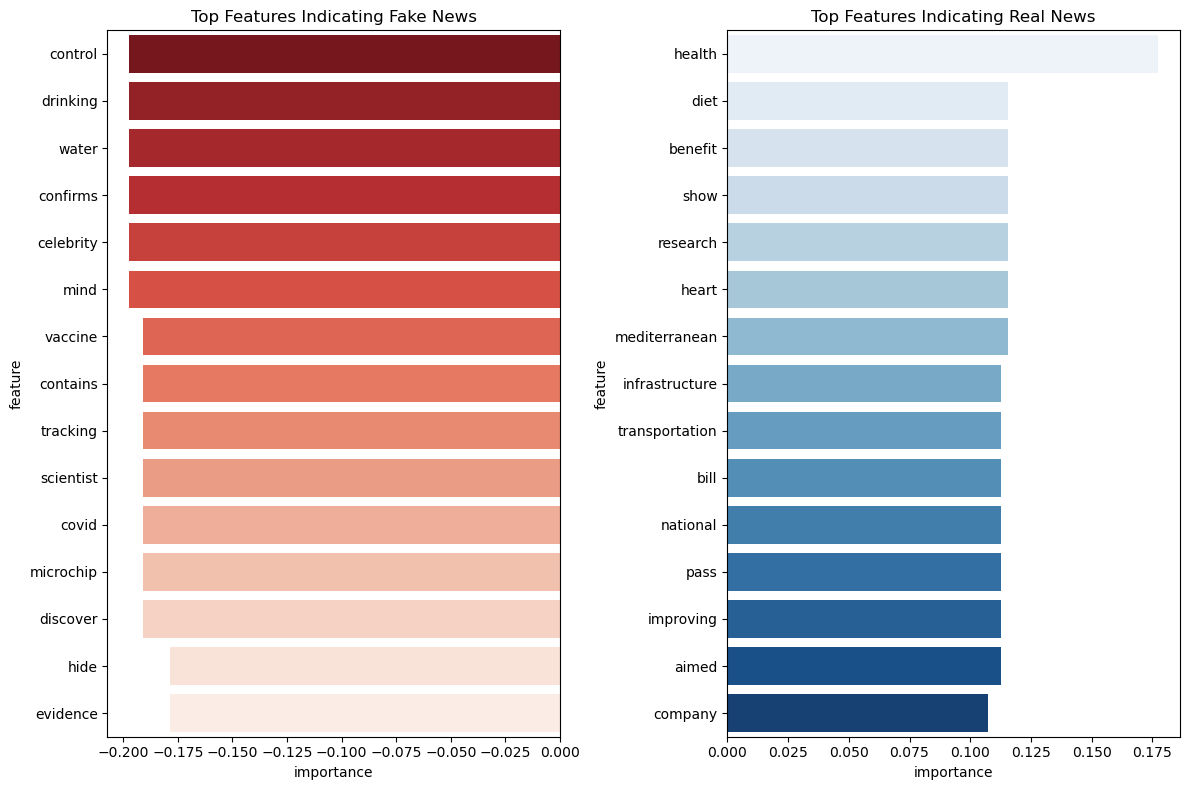

In [10]:
# 7. Feature Importance Analysis
# ----------------------------

print("Analyzing most indicative features...")

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients from the model
coefficients = model.coef_[0]

# Create DataFrame for visualization
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
})

# Sort by absolute importance
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = feature_importance.sort_values('abs_importance', ascending=False)

# Plot top features for fake and real news
plt.figure(figsize=(12, 8))

# Top indicators of fake news (negative coefficients)
plt.subplot(1, 2, 1)
fake_features = feature_importance[feature_importance['importance'] < 0].head(15)
sns.barplot(x='importance', y='feature', data=fake_features, palette='Reds_r')
plt.title('Top Features Indicating Fake News')

# Top indicators of real news (positive coefficients)
plt.subplot(1, 2, 2)
real_features = feature_importance[feature_importance['importance'] > 0].head(15)
sns.barplot(x='importance', y='feature', data=real_features, palette='Blues')
plt.title('Top Features Indicating Real News')

plt.tight_layout()
plt.show()


In [11]:
# 8. Create a Function to Predict News Authenticity
# ----------------------------------------------

def predict_news_authenticity(news_text, model, vectorizer):
    """
    Predict whether a news article is fake or real
    
    Parameters:
    news_text (str): The news text to classify
    model: Trained classification model
    vectorizer: Fitted TF-IDF vectorizer
    
    Returns:
    tuple: (prediction label, probability)
    """
    # Preprocess the text
    processed_text = preprocess_text(news_text)
    
    # Transform text using vectorizer
    text_tfidf = vectorizer.transform([processed_text])
    
    # Make prediction
    prediction = model.predict(text_tfidf)[0]
    
    # Get probability
    proba = model.predict_proba(text_tfidf)[0]
    
    return prediction, proba

# Example usage of the prediction function
test_news_articles = [
    "Scientists discover revolutionary new treatment that cures all types of cancer overnight",
    "Study shows moderate coffee consumption may have health benefits, according to research published in medical journal"
]

print("\nTesting the model with new articles:")
for article in test_news_articles:
    print(f"\nArticle: {article}")
    prediction, proba = predict_news_authenticity(article, model, tfidf_vectorizer)
    
    # Display result
    if prediction == 1:
        print(f"Prediction: Real News (Confidence: {proba[1]:.2f})")
    else:
        print(f"Prediction: Fake News (Confidence: {proba[0]:.2f})")



Testing the model with new articles:

Article: Scientists discover revolutionary new treatment that cures all types of cancer overnight
Prediction: Real News (Confidence: 0.59)

Article: Study shows moderate coffee consumption may have health benefits, according to research published in medical journal
Prediction: Real News (Confidence: 0.69)


In [12]:
# 9. Fetch and Classify Real-Time News (in a real implementation)
# -----------------------------------------------------------

def classify_api_news(api_key, model, vectorizer, num_articles=5):
    """
    Fetch news from API and classify them as fake or real
    
    Parameters:
    api_key (str): News API key
    model: Trained model
    vectorizer: Fitted TF-IDF vectorizer
    num_articles (int): Number of articles to classify
    """
    # In a real implementation, you would call:
    # articles = fetch_news_from_api(api_key, page_size=num_articles)
    
    # For demonstration, use example articles
    example_articles = [
        {
            'title': 'Global temperatures reach record high for third consecutive month',
            'description': 'Scientists report rising trends in global average temperatures according to satellite data.',
            'content': 'The World Meteorological Organization confirmed today that global temperatures have reached a new record high for the third consecutive month. This trend aligns with climate models predicting increasing average temperatures due to greenhouse gas emissions.'
        },
        {
            'title': 'New study links healthy diet to increased lifespan',
            'description': 'Research published in a peer-reviewed journal shows connection between nutrition and longevity.',
            'content': 'A comprehensive study involving over 10,000 participants found that people who maintain a balanced diet rich in vegetables, fruits, and whole grains tend to live longer. The research controlled for factors such as exercise, smoking, and genetic predisposition.'
        },
        {
            'title': 'Secret government program controls weather patterns',
            'description': 'Whistleblower reveals classified weather modification technology.',
            'content': 'An anonymous source claims the government has been using advanced technology to control rainfall and temperature patterns across the country for decades. The alleged program reportedly aims to influence agricultural outcomes and cause targeted droughts.'
        }
    ]
    
    print("\nClassifying recent news articles:")
    for i, article in enumerate(example_articles, 1):
        # Combine title, description and content
        full_text = f"{article['title']} {article['description']} {article['content']}"
        
        # Predict authenticity
        prediction, proba = predict_news_authenticity(full_text, model, vectorizer)
        
        # Display result
        print(f"\nArticle {i}: {article['title']}")
        if prediction == 1:
            print(f"Prediction: Real News (Confidence: {proba[1]:.2f})")
        else:
            print(f"Prediction: Fake News (Confidence: {proba[0]:.2f})")

# Example usage (in a real implementation, you would use your actual API key)
# classify_api_news("YOUR_API_KEY", model, tfidf_vectorizer)
classify_api_news(None, model, tfidf_vectorizer)  # Using None as placeholder for API key


Classifying recent news articles:

Article 1: Global temperatures reach record high for third consecutive month
Prediction: Real News (Confidence: 0.65)

Article 2: New study links healthy diet to increased lifespan
Prediction: Real News (Confidence: 0.68)

Article 3: Secret government program controls weather patterns
Prediction: Real News (Confidence: 0.58)
